In [22]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
from sklearn.preprocessing import StandardScaler
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns


In [23]:
df_train = pd.read_csv("train_data.csv")
df_train = df_train.drop(columns="SubwayStation")

df_test = pd.read_csv("test_data.csv")
df_test = df_test.drop(columns=["SubwayStation"])
df_train["SalePrice"].values[0]

141592

Spytac sie prowadzacych czy OHE jest lepsze, czy mapping; jakby ujowo działało, to dorzucic stacje metra jeszcze

In [24]:
def encode_data(df:pd.DataFrame):
    busTimeMapping = {'5min~10min': 2, '0~5min': 1, '10min~15min': 3}
    subwayTimeMapping = {'5min~10min': 2, '0-5min': 1, '10min~15min': 3, '15min~20min':4, 'no_bus_stop_nearby':5}

    df['TimeToBusStop'] = df['TimeToBusStop'].replace(busTimeMapping)
    df['TimeToSubway'] = df['TimeToSubway'].replace(subwayTimeMapping)

    # nie wiem czy jest roznica miedzy mappingiem czy OHE

    df = pd.get_dummies(df, columns=["HallwayType", "HeatingType", "AptManageType"])

    return df



def encode_labels(df:pd.DataFrame):
    i=0
    for value in df.SalePrice.values:
        if value < 100000:
            df.SalePrice.values[i] = 0
        elif value < 350000:
            df.SalePrice.values[i] = 1
        else:
            df.SalePrice.values[i] = 2
        i += 1
    return df

array([[<Axes: title={'center': 'SalePrice'}>,
        <Axes: title={'center': 'YearBuilt'}>,
        <Axes: title={'center': 'Size(sqf)'}>],
       [<Axes: title={'center': 'Floor'}>,
        <Axes: title={'center': 'N_Parkinglot(Ground)'}>,
        <Axes: title={'center': 'N_Parkinglot(Basement)'}>],
       [<Axes: title={'center': 'N_manager'}>,
        <Axes: title={'center': 'N_elevators'}>,
        <Axes: title={'center': 'N_FacilitiesInApt'}>],
       [<Axes: title={'center': 'N_FacilitiesNearBy(Total)'}>,
        <Axes: title={'center': 'N_SchoolNearBy(Total)'}>, <Axes: >]],
      dtype=object)

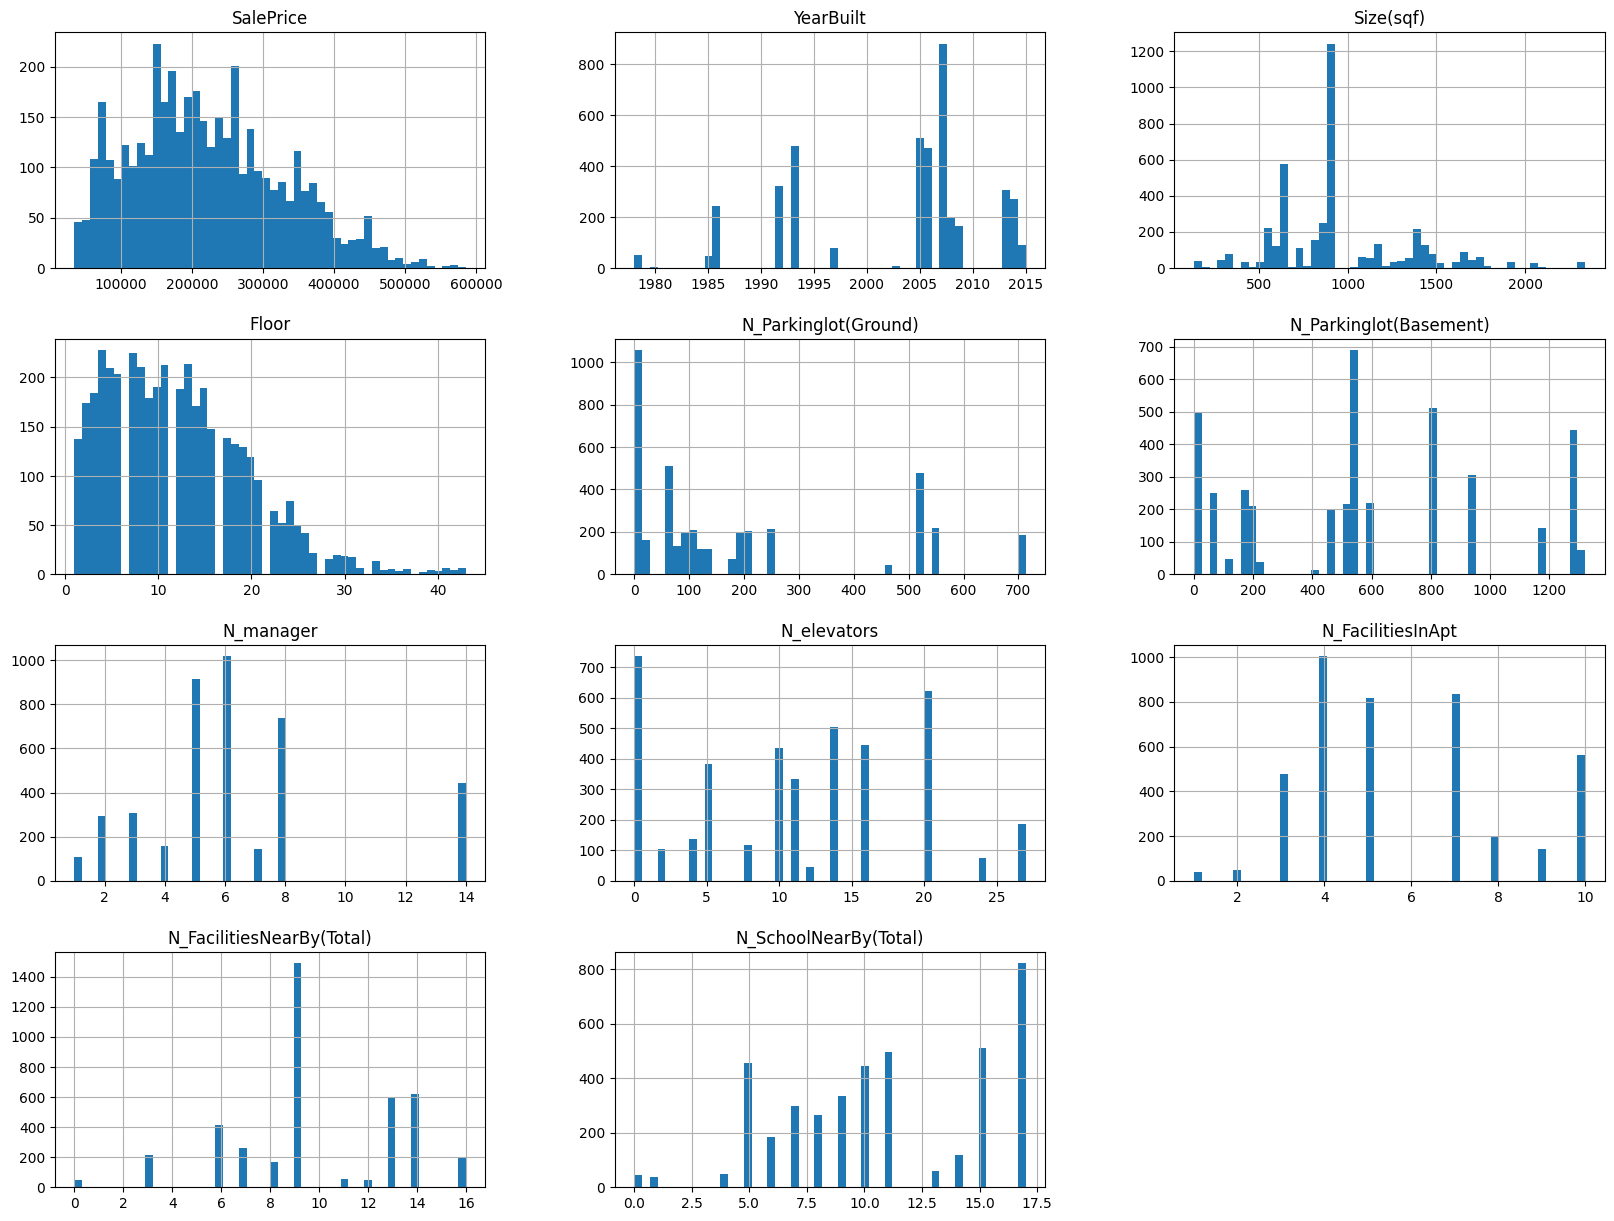

In [25]:
df_train.hist(bins=50, figsize=(20,15))

In [26]:
df_train = encode_data(df_train)
df_train = encode_labels(df_train)
df_test = encode_data(df_test)



/tmp/ipykernel_99632/2833201351.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['TimeToBusStop'] = df['TimeToBusStop'].replace(busTimeMapping)
/tmp/ipykernel_99632/2833201351.py:6: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['TimeToSubway'] = df['TimeToSubway'].replace(subwayTimeMapping)
/tmp/ipykernel_99632/2833201351.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to 

<Axes: xlabel='SalePrice'>

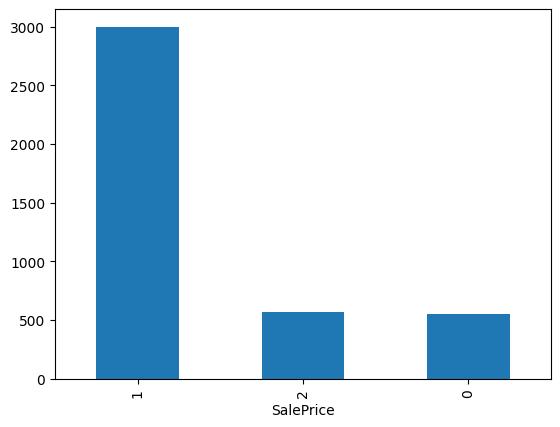

In [27]:
ee = df_train.SalePrice.value_counts()
ee.plot(kind='bar')

<Axes: >

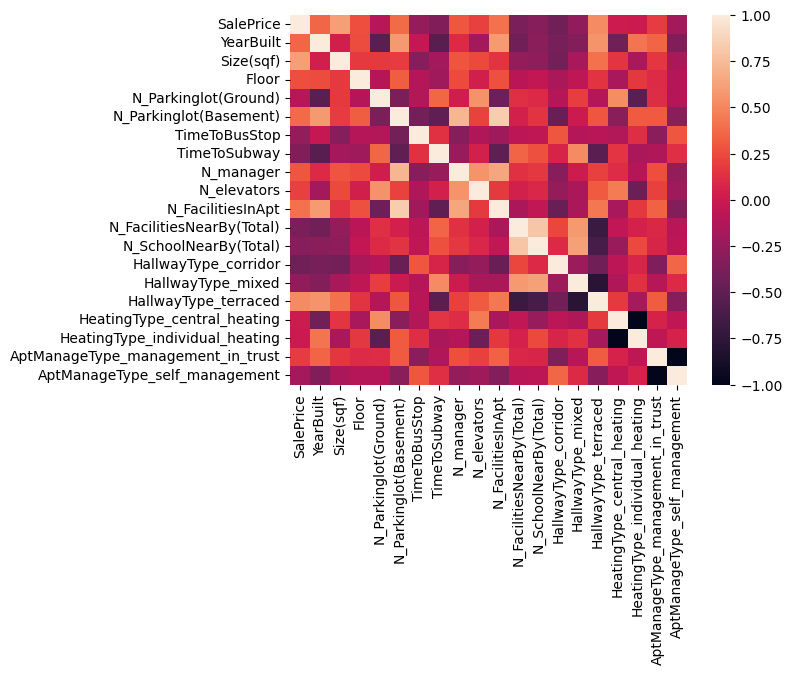

In [28]:
sns.heatmap(df_train.corr())

In [29]:
df_train = pd.get_dummies(df_train, columns=["SalePrice"])

In [30]:
train = df_train.sample(frac=0.80, random_state=112)
# print(train.SalePrice.value_counts())
val = df_train.drop(train.index)
# print(val.SalePrice.value_counts())

In [31]:
X_train = train.values[:, :-3].astype('float32')
X_val = val.values[:, :-3].astype('float32')
X_test = df_test.values.astype('float32')

Y_train = train.values[:, -3:].astype('float32')
Y_val = val.values[:, -3:].astype('float32')

In [32]:
# normalizacja scalerem filtrowanym do danych treningowych
scaler = StandardScaler()
scaler.fit(np.vstack((X_train, X_val)))
X_train_norm = scaler.transform(X_train)
X_val_norm = scaler.transform(X_val)
X_test_norm = scaler.transform(X_test)


In [33]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

device

device(type='cpu')

In [34]:
train_ds = data.TensorDataset(torch.from_numpy(X_train_norm).to(device),torch.from_numpy(Y_train).to(device))
val_ds = data.TensorDataset(torch.from_numpy(X_val_norm).to(device),torch.from_numpy(Y_val).to(device))
test_ds = data.TensorDataset(torch.from_numpy(X_test_norm).to(device),torch.zeros(X_test_norm.shape[0], 1).to(device))

train_loader = data.DataLoader(train_ds, shuffle=True, batch_size=X_train_norm.shape[0])
val_loader = data.DataLoader(val_ds, batch_size=X_val_norm.shape[0])
test_loader = data.DataLoader(test_ds, batch_size=1000)

In [35]:
class Aproximator(nn.Module):

    def __init__(self, num_inputs, num_labels, hidden_size = [30, 30, 30], BN=False, dropout=0):
        super(Aproximator,self).__init__()

        layers = []
        layer_sizes = [num_inputs] + hidden_size
        for layer in range (1, len(layer_sizes)): # tu sie moze jebie
            if BN:
                layers += [nn.Linear(layer_sizes[layer-1], layer_sizes[layer]),
                           nn.BatchNorm1d(layer_sizes[layer]),
                           nn.Dropout(dropout),
                           torch.nn.LeakyReLU()
                           ]
            else:
                layers += [nn.Linear(layer_sizes[layer-1], layer_sizes[layer]),
                           nn.Dropout(dropout),
                           torch.nn.LeakyReLU()
                           ]
        layers += [nn.Linear(layer_sizes[-1], num_labels)]

        self.layers = nn.Sequential(*layers)

    def forward(self, x):
        return self.layers(x)


In [36]:

####### Parametry
weight_decay = 1e-3
lr = 1e-3

input_size = X_train_norm.shape[1]
out_size = Y_train.shape[1]
hidden_sizes = [100, 80, 50, 30]
# hidden_sizes = [1]
dropout = 0.2
BN=True

weights_loss = torch.tensor([6.86, 1.33, 7.27])

epoch = 5000
max_lr = .01

#######
Aprox1 = Aproximator(input_size, out_size, hidden_sizes, BN=BN, dropout=dropout).to(device)


optim = torch.optim.Adam(Aprox1.parameters(), weight_decay=weight_decay, lr=lr)
sched = torch.optim.lr_scheduler.OneCycleLR(optim, max_lr, epochs=epoch, steps_per_epoch=len(train_loader))
loss_fnc = torch.nn.CrossEntropyLoss(weight=weights_loss).to(device)

In [37]:
def measure_accuracy_and_loss_val(model, data_loader):
    positive=0
    total = 0
    loss_sum = []

    with torch.no_grad():
        model.eval()
        for input, labels in data_loader:
            output = torch.softmax(model(input), dim=1)

            loss_sum += [loss_fnc(output, labels).item()]

            positive += sum(torch.argmax(output, dim=1) == torch.argmax(labels, dim=1))

            total+=input.shape[0]


    return  positive/total, np.array(loss_sum).mean()

In [38]:
def train(data_loader, epoch):

    Aprox1.train(mode=True)

    acc_val=[]
    loss_train=[]
    loss_val=[]
    epochs=[]

    for n in range(epoch):

        epoch_losses = []
        for input, label in data_loader:

            pred = Aprox1.forward(input)
            loss = loss_fnc(pred, label)

            optim.zero_grad()
            loss.backward()
            optim.step()
            sched.step()

            epoch_losses.append(loss.item())


        if n%100==0:
            loss_mean = np.array(epoch_losses).mean()
            val_acc, val_loss = measure_accuracy_and_loss_val(Aprox1, val_loader)

            acc_val.append(val_acc.cpu())
            loss_val.append(val_loss)
            loss_train.append(loss_mean)
            epochs.append(n)

            print(f"Epoch {n}; train_loss {loss_mean:.3}; val_loss {val_loss:.3}; val_acc {val_acc:.3}")

    Aprox1.eval()

    plt.plot(epochs,loss_val, label="val loss")
    plt.plot(epochs,loss_train, label="train loss")
    plt.title("Loss")
    plt.legend()
    plt.show()


    plt.plot(epochs, acc_val, label="val accuracy")
    plt.title("Accuracy")
    plt.legend()
    plt.show()



In [39]:
train(train_loader, epoch)

Epoch 0; train_loss 3.52; val_loss 3.14; val_acc 0.127


KeyboardInterrupt: 

In [ ]:
# model_path = 'With_BN__dropout__L2reg__500epoch__81acc__lossWeights717__LRELU.pth'
# torch.save(Aprox1.state_dict(), model_path)

In [ ]:
# evalke na testowym jeszcze + zapis do pliku + rzutowanie na [0, 1, 2]